In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from mne import read_epochs, compute_rank
from mne.decoding import CSP
from mne.preprocessing import ICA
from mne.time_frequency import tfr_multitaper
from mne.decoding import UnsupervisedSpatialFilter

from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score, ShuffleSplit

from jupyterthemes.stylefx import set_nb_theme
set_nb_theme('gruvboxd')

In [29]:
epochs = read_epochs('ica_epo.fif')
epochs

Reading C:\Users\Alberto\Documents\BCI\data\esn\ica_epo.fif ...
    Found the data of interest:
        t =   -2000.00 ...    7999.02 ms
        0 CTF compensation matrices available
Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated


Number of events,62
Events,left: 14r_pinch: 7r_stop: 16rest: 11right: 14
Time range,-2.000 – 7.999 sec
Baseline,off


Time Frequency Analysis

In [5]:
channels = ['FC5','FC3','C3','C5','CP3','CP5','P3']
conditions = ['left','right','rest']
tmin = -0.1
tmax = 1.5

In [6]:
freqs = np.arange(7,120)
freq_bounds = {
    '_': 0,
    'delta': 3,
    'theta': 7,
    'alpha': 13,
    'beta' : 35,
    'l-gamma': 70,
    'm-gamma': 90,
    'h-gamma': 120
}


In [10]:
tfr = tfr_multitaper(epochs[conditions].copy().filter(1,120,n_jobs=8).pick(channels), freqs=freqs, n_cycles=freqs, n_jobs=8, use_fft=True,
        return_itc=False, average=False, decim=2)
tfr.apply_baseline((-1.2,-0.1), mode='percent')
tfr.crop(tmin,tmax)

Setting up band-pass filter from 1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 120.00 Hz
- Upper transition bandwidth: 30.00 Hz (-6 dB cutoff frequency: 135.00 Hz)
- Filter length: 3381 samples (3.302 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 1528 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done 2450 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done 2496 out of 2496 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   7 | elapsed:   22.6s remaining:   56.5s
[Parallel(n_jobs=8)]: Done   4 out of   7 | elapsed:   23.4s remaining:   17.5s
[Parallel(n_jobs=8)]: Done   7 out of   7 | elapsed:   24.6s finished


Not setting metadata
Applying baseline correction (mode: percent)


<EpochsTFR | time : [-0.099609, 1.500000], freq : [7.000000, 119.000000], epochs : 39, channels : 7, ~193.0 MB>

In [11]:
df = tfr.to_data_frame(time_format=None, long_format=True)
df['band'] = pd.cut(df['freq'], list(freq_bounds.values()), labels=list(freq_bounds)[1:])

Converting "condition" to "category"...
Converting "epoch" to "category"...
Converting "channel" to "category"...
Converting "ch_type" to "category"...


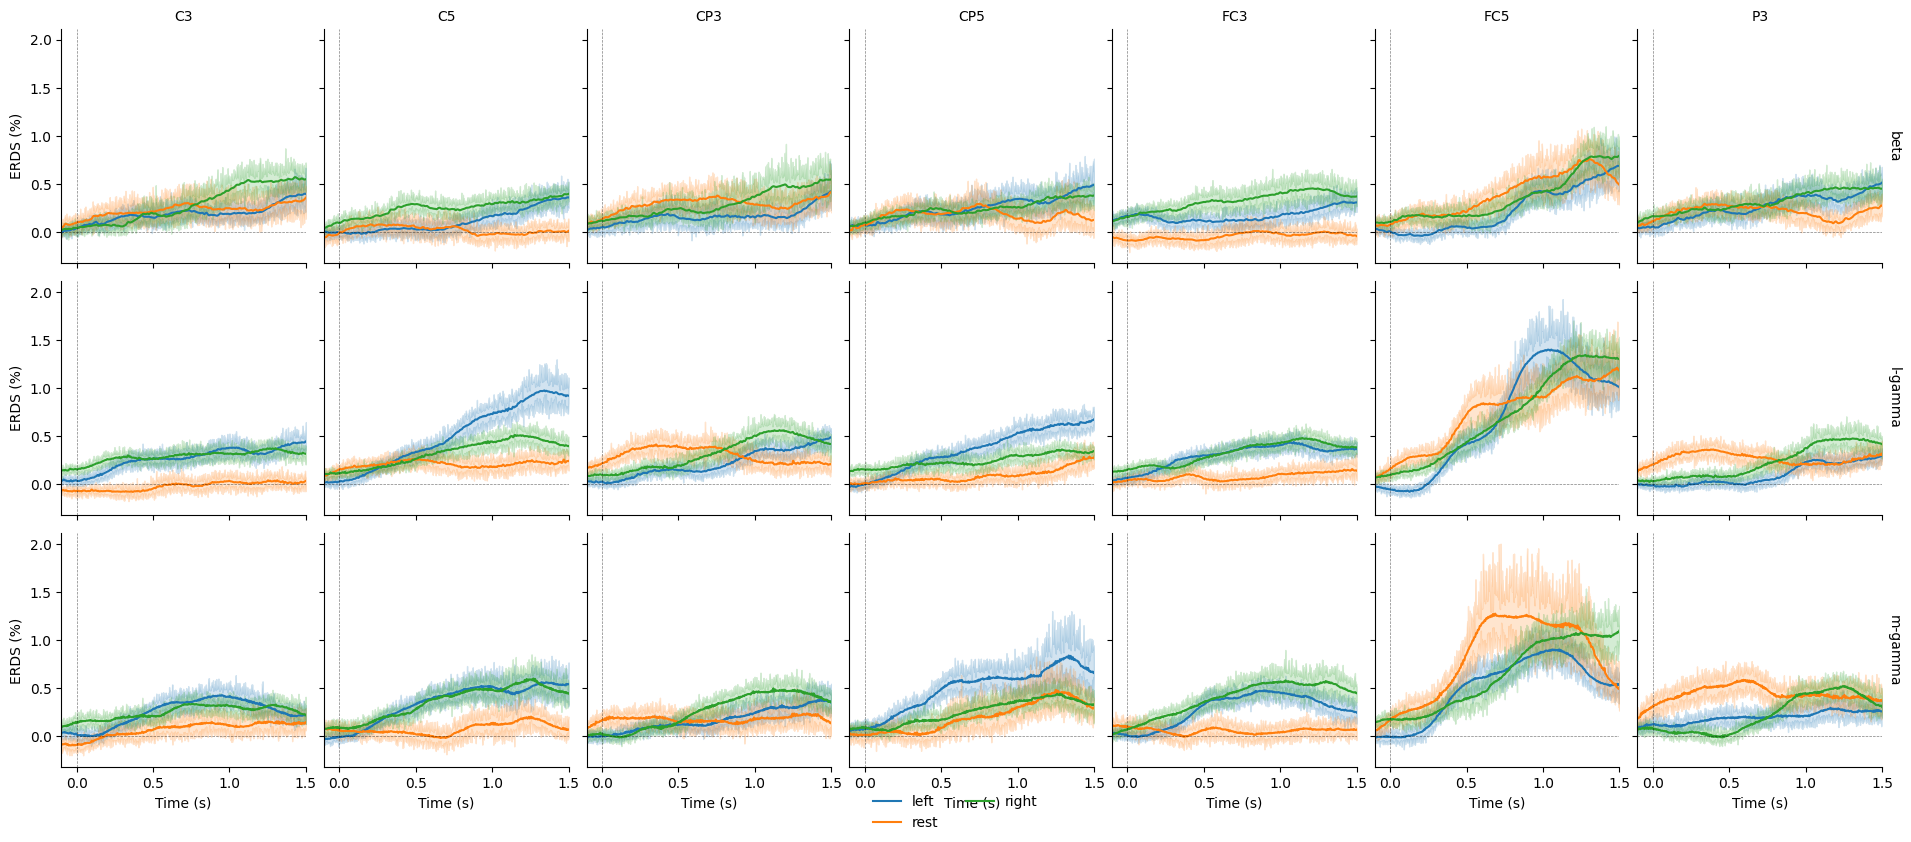

In [12]:
df = df[df.band.isin(['beta','l-gamma','m-gamma'])]
df['band'] = df['band'].cat.remove_unused_categories()
g = sns.FacetGrid(df, row='band', col='channel', margin_titles=True)
g.map(sns.lineplot, 'time', 'value', 'condition', n_boot=10)
axline_kw = dict(color='black', linestyle='dashed', linewidth=0.5, alpha=0.5)
g.map(plt.axhline, y=0, **axline_kw)
g.map(plt.axvline, x=0, **axline_kw)
# g.set(ylim=(None, 1.5))
g.set(xlim=(tmin, tmax))
g.set_axis_labels("Time (s)", "ERDS (%)")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend(ncol=2, loc='lower center')
g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.08)

Binary CSP + LDA classification

In [13]:
conditions = ['left','rest']
subset = epochs[conditions].copy()
subset.drop_channels(subset.info['bads'])
subset = subset.pick(['eeg'])
compute_rank(subset)

Computing rank from data with rank=None
    Using tolerance 1.9e-08 (2.2e-16 eps * 63 dim * 1.4e+06  max singular value)
    Estimated rank (eeg): 63
    EEG: rank 63 computed from 63 data channels with 0 projectors


{'eeg': 63}

In [14]:
min_freq = 7.
max_freq = 120.
tmin = -0.1
tmax = 1.8
n_freqs = 10  # how many frequency bins to use
components = 2
classes = list(subset.event_id.keys())

In [15]:
csp = CSP(n_components=components, reg=None, log=True, norm_trace=False, rank='info')
clf = make_pipeline(csp, LinearDiscriminantAnalysis())
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=34)
le = LabelEncoder()

In [16]:
freqs = np.linspace(min_freq, max_freq, n_freqs)
freq_ranges = list(zip(freqs[:-1], freqs[1:]))
freq_labels = []
freq_scores = []

In [17]:
subset = subset.apply_baseline((-1.5,-0.5))
y = le.fit_transform(subset.events[:,2])

Applying baseline correction (mode: mean)


Computing rank from data with rank='info'
    MAG: rank 63 after 0 projectors applied to 63 channels
Reducing data rank from 63 -> 63
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='info'
    MAG: rank 63 after 0 projectors applied to 63 channels
Reducing data rank from 63 -> 63
Estimating covariance using EMPIRICAL
Done.


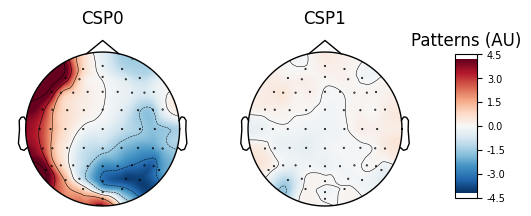

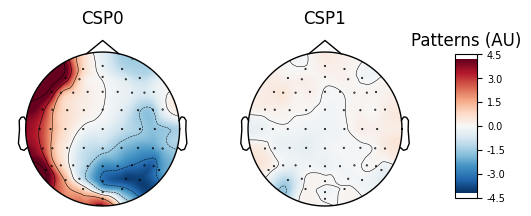

In [18]:
csp.fit(subset.copy().crop(tmin,tmax).filter(5, 20, n_jobs=4, verbose=False).get_data(),y)
csp.plot_patterns(subset.info, ch_type='eeg', units='Patterns (AU)', size=1.5)

Computing rank from data with rank='info'
    MAG: rank 63 after 0 projectors applied to 63 channels
Reducing data rank from 63 -> 63
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='info'
    MAG: rank 63 after 0 projectors applied to 63 channels
Reducing data rank from 63 -> 63
Estimating covariance using EMPIRICAL
Done.


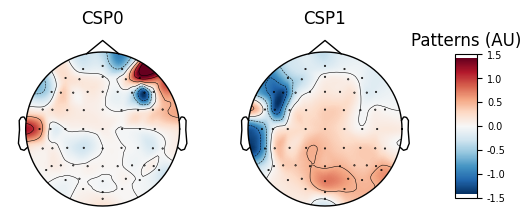

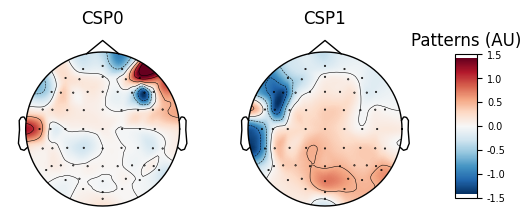

In [19]:
csp.fit(subset.copy().crop(tmin,tmax).filter(20,35 , n_jobs=4, verbose=False).get_data(),y)
csp.plot_patterns(subset.info, ch_type='eeg', units='Patterns (AU)', size=1.5)

Computing rank from data with rank='info'
    MAG: rank 63 after 0 projectors applied to 63 channels
Reducing data rank from 63 -> 63
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='info'
    MAG: rank 63 after 0 projectors applied to 63 channels
Reducing data rank from 63 -> 63
Estimating covariance using EMPIRICAL
Done.


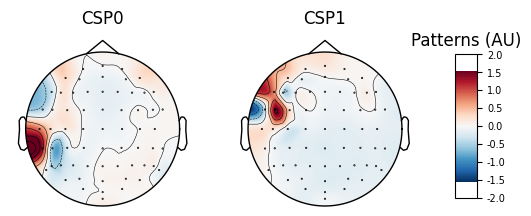

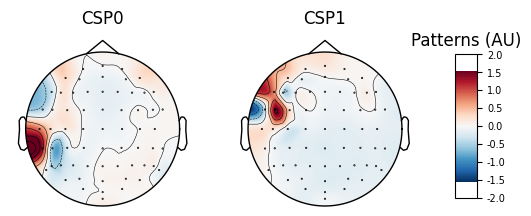

In [20]:
csp.fit(subset.copy().crop(tmin,tmax).filter(70,90 , n_jobs=4, verbose=False).get_data(),y)
csp.plot_patterns(subset.info, ch_type='eeg', units='Patterns (AU)', size=1.5)

In [21]:
for freq, (fmin, fmax) in enumerate(freq_ranges):
    test = subset.copy().crop(tmin,tmax).filter(fmin, fmax, n_jobs=4) 
    test.drop_channels(test.info['bads'])
    
    if tmin > 3 and (conditions[1] == 'rest'):
        rest = subset['rest'].copy().crop(0, tmax-tmin).filter(fmin, fmax, n_jobs=4)
        rest.drop_channels(rest.info['bads'])
        X = np.concatenate([test[condtion[0]].get_data(), rest.get_data()])
    else:
        X = test.get_data()
    
    chance = np.mean(y == y[0])
    chance = max(chance, 1. - chance)
        
    freq_labels.append(str(int(fmax)))
    freq_scores.append(
        cross_val_score(
            estimator=clf, X=X, y=y, scoring='roc_auc', cv=cv, n_jobs=8))
    
    print(freq_labels)
    print('SCORE '+str(np.mean(freq_scores)))

Setting up band-pass filter from 7 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 19.56 Hz
- Upper transition bandwidth: 4.89 Hz (-6 dB cutoff frequency: 22.00 Hz)
- Filter length: 1691 samples (1.651 sec)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 1488 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1575 out of 1575 | elapsed:    0.4s finished


['19']
SCORE nan
Setting up band-pass filter from 20 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 19.56
- Lower transition bandwidth: 4.89 Hz (-6 dB cutoff frequency: 17.11 Hz)
- Upper passband edge: 32.11 Hz
- Upper transition bandwidth: 8.03 Hz (-6 dB cutoff frequency: 36.12 Hz)
- Filter length: 693 samples (0.677 sec)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 1296 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 1575 out of 1575 | elapsed:    1.8s finished


['19', '32']
SCORE nan
Setting up band-pass filter from 32 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 32.11
- Lower transition bandwidth: 8.03 Hz (-6 dB cutoff frequency: 28.10 Hz)
- Upper passband edge: 44.67 Hz
- Upper transition bandwidth: 11.17 Hz (-6 dB cutoff frequency: 50.25 Hz)
- Filter length: 421 samples (0.411 sec)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 1344 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 1575 out of 1575 | elapsed:    1.8s finished


['19', '32', '44']
SCORE nan
Setting up band-pass filter from 45 - 57 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 44.67
- Lower transition bandwidth: 11.17 Hz (-6 dB cutoff frequency: 39.08 Hz)
- Upper passband edge: 57.22 Hz
- Upper transition bandwidth: 14.31 Hz (-6 dB cutoff frequency: 64.38 Hz)
- Filter length: 303 samples (0.296 sec)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 1296 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 1575 out of 1575 | elapsed:    1.8s finished


['19', '32', '44', '57']
SCORE nan
Setting up band-pass filter from 57 - 70 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 57.22
- Lower transition bandwidth: 14.31 Hz (-6 dB cutoff frequency: 50.07 Hz)
- Upper passband edge: 69.78 Hz
- Upper transition bandwidth: 17.44 Hz (-6 dB cutoff frequency: 78.50 Hz)
- Filter length: 237 samples (0.231 sec)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 1344 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 1575 out of 1575 | elapsed:    1.9s finished


['19', '32', '44', '57', '69']
SCORE nan
Setting up band-pass filter from 70 - 82 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 69.78
- Lower transition bandwidth: 17.44 Hz (-6 dB cutoff frequency: 61.06 Hz)
- Upper passband edge: 82.33 Hz
- Upper transition bandwidth: 20.58 Hz (-6 dB cutoff frequency: 92.62 Hz)
- Filter length: 195 samples (0.190 sec)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 1344 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 1575 out of 1575 | elapsed:    1.8s finished


['19', '32', '44', '57', '69', '82']
SCORE nan
Setting up band-pass filter from 82 - 95 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 82.33
- Lower transition bandwidth: 20.58 Hz (-6 dB cutoff frequency: 72.04 Hz)
- Upper passband edge: 94.89 Hz
- Upper transition bandwidth: 23.72 Hz (-6 dB cutoff frequency: 106.75 Hz)
- Filter length: 165 samples (0.161 sec)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 1296 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 1575 out of 1575 | elapsed:    1.8s finished


['19', '32', '44', '57', '69', '82', '94']
SCORE nan
Setting up band-pass filter from 95 - 1.1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 94.89
- Lower transition bandwidth: 23.72 Hz (-6 dB cutoff frequency: 83.03 Hz)
- Upper passband edge: 107.44 Hz
- Upper transition bandwidth: 26.86 Hz (-6 dB cutoff frequency: 120.88 Hz)
- Filter length: 143 samples (0.140 sec)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 1344 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 1575 out of 1575 | elapsed:    1.8s finished


['19', '32', '44', '57', '69', '82', '94', '107']
SCORE nan
Setting up band-pass filter from 1.1e+02 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 107.44
- Lower transition bandwidth: 26.86 Hz (-6 dB cutoff frequency: 94.01 Hz)
- Upper passband edge: 120.00 Hz
- Upper transition bandwidth: 30.00 Hz (-6 dB cutoff frequency: 135.00 Hz)
- Filter length: 127 samples (0.124 sec)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 1296 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 1575 out of 1575 | elapsed:    2.0s finished


['19', '32', '44', '57', '69', '82', '94', '107', '120']
SCORE nan


In [22]:
scores_df = pd.DataFrame(data=np.transpose(freq_scores), columns=[freq_labels])

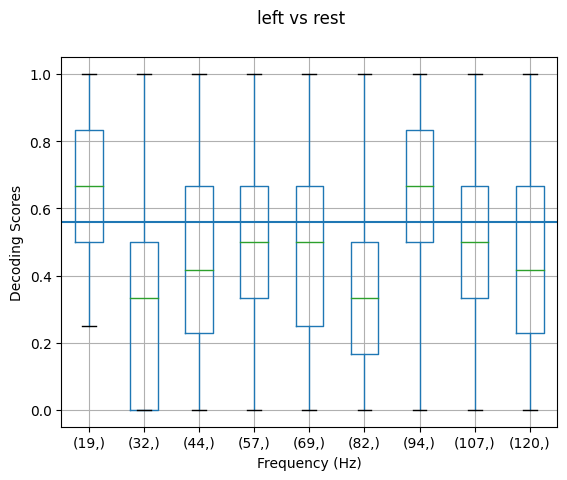

In [23]:
csp_fig, axes = plt.subplots(1)
scores_df.boxplot(ax=axes)
axes.axhline(chance)
axes.set_xlabel('Frequency (Hz)')
axes.set_ylabel('Decoding Scores')
csp_fig.suptitle(classes[0]+' vs '+classes[1])
plt.show()

In [24]:
scores_df
score_mean = []
for col in scores_df.columns:
    score_mean.append(np.mean(scores_df[col]))

In [25]:
score_mean

[0.7083333333333334,
 0.35763888888888884,
 0.4288194444444444,
 0.4947916666666667,
 0.4826388888888889,
 0.3524305555555556,
 0.6354166666666669,
 0.48784722222222227,
 0.4270833333333333]